<a href="https://colab.research.google.com/github/maxmatical/TMLS_NLP/blob/master/twitter__sentiment_BERT.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:
%%capture
!pip install git+https://github.com/fastai/fastai.git

In [0]:
# Set up environment and download course-v3
!curl -s https://course.fast.ai/setup/colab | bash

Updating fastai...
Done.


In [0]:
!pip install pretrainedmodels

!pip install pytorch-pretrained-bert

     |████████████████████████████████| 61kB 2.4MB/s 
  Created wheel for pretrainedmodels: filename=pretrainedmodels-0.7.4-cp36-none-any.whl size=60963 sha256=a24dccfa824eba6cd4d346102f4a4c3314cf3b5f220e6f0720609fad8b09c837
  Stored in directory: /root/.cache/pip/wheels/69/df/63/62583c096289713f22db605aa2334de5b591d59861a02c2ecd
  Created wheel for munch: filename=munch-2.3.2-py2.py3-none-any.whl size=6614 sha256=45c8b7ef5aecfc48ae5462aeca926836826800e95686752a8e148e0fd689a0e6
  Stored in directory: /root/.cache/pip/wheels/db/bf/bc/06a3e1bfe0ab27d2e720ceb3cff3159398d92644c0cec2c125
Successfully built pretrainedmodels munch
     |████████████████████████████████| 133kB 2.8MB/s 
     |████████████████████████████████| 645kB 44.2MB/s 


In [0]:
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt

from fastai import *
from fastai.text import *
from fastai.utils.show_install import *
from fastai.callbacks import *

# import torch
show_install()



```text
=== Software === 
python        : 3.6.8
fastai        : 1.0.59.dev0
fastprogress  : 0.1.21
torch         : 1.2.0
nvidia driver : 418.67
torch cuda    : 10.0.130 / is available
torch cudnn   : 7602 / is enabled

=== Hardware === 
nvidia gpus   : 1
torch devices : 1
  - gpu0      : 11441MB | Tesla K80

=== Environment === 
platform      : Linux-4.14.137+-x86_64-with-Ubuntu-18.04-bionic
distro        : #1 SMP Thu Aug 8 02:47:02 PDT 2019
conda env     : Unknown
python        : /usr/bin/python3
sys.path      : 
/env/python
/usr/lib/python36.zip
/usr/lib/python3.6
/usr/lib/python3.6/lib-dynload
/usr/local/lib/python3.6/dist-packages
/usr/lib/python3/dist-packages
/usr/local/lib/python3.6/dist-packages/IPython/extensions
/root/.ipython
```

Please make sure to include opening/closing ``` when you paste into forums/github to make the reports appear formatted as code sections.

Optional package(s) to enhance the diagnostics can be installed with:
pip install distro
Once installed, re-

In [0]:
# from fastai.callbacks import *
# from fastai import *

In [0]:
# import fastai
# fastai.device = torch.device('cpu')
# fastai.device

# EDA

In [0]:
df = pd.read_csv('testset1.csv')

In [0]:
print(len(df))

df.head(5)

5585


,id,name,date,text,location,sentiment
0,1.130000e+18,Evolutionomics,Sun May 19 23:57:10 +0000 2019,By combining short positions on #Gold $GOLD $G...,NaN,bearish
1,1.130000e+18,macrohedged,Sun May 19 23:55:02 +0000 2019,Here are the #Volatility levels for the majors...,England,unrelated
2,1.130000e+18,Evolutionomics,Sun May 19 23:54:06 +0000 2019,We have little insight into what will happen t...,NaN,neutral
3,1.130000e+18,Evolutionomics,Sun May 19 23:50:59 +0000 2019,"This brings us to #Gold miners. As a group, $G...",NaN,neutral
4,1.130000e+18,macrohedged,Sun May 19 23:50:04 +0000 2019,"Good morning Asia, here are the benchmark futu...",England,unrelated


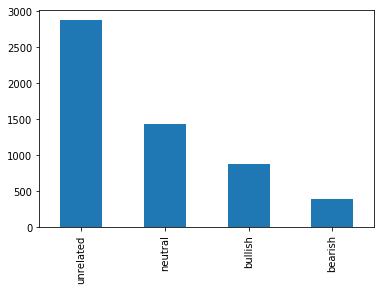

In [0]:
df['sentiment'].value_counts().plot(kind='bar')

Unrelated and neutral sentiments dominate the data currently (although this might not be the case in the future with the full dataset). It might be better to use a stratified sampling technique for classification

In [0]:
from sklearn.model_selection import StratifiedShuffleSplit

sss = StratifiedShuffleSplit(n_splits=5, test_size=0.2, random_state=0)
sss.get_n_splits(df['text'], df['sentiment'])

print(sss)



StratifiedShuffleSplit(n_splits=5, random_state=0, test_size=0.2,
            train_size=None)


In [0]:
train_idx, val_idx = next(sss.split(df['text'], df['sentiment']))

print(len(train_idx), len(val_idx))

4468 1117


Verifying that the stratified split preseves the distribution of the labels

In [0]:
df_train = df.iloc[train_idx, :]
df_val = df.iloc[val_idx, :]

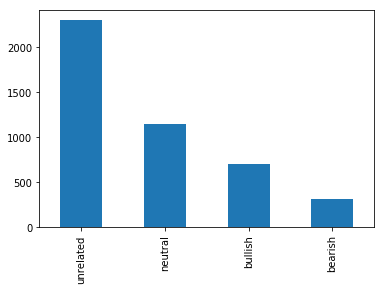

In [0]:
df_train['sentiment'].value_counts().plot(kind='bar')

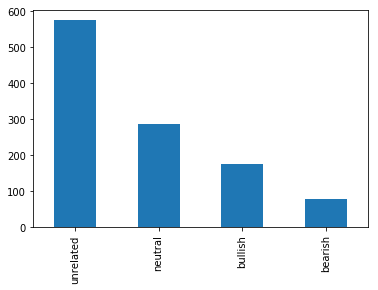

In [0]:
df_val['sentiment'].value_counts().plot(kind='bar')

Looks like the distribution of the labels in train and val are the same, so we can start modelling now

# Handling Imbalanced Data: Oversampling

In [0]:
df_class_bull = df_train[df_train['sentiment'] == 'bullish']
df_class_bear = df_train[df_train['sentiment'] == 'bearish']
df_class_neutral = df_train[df_train['sentiment'] == 'neutral']
df_class_unrelated = df_train[df_train['sentiment'] == 'unrelated']



In [0]:
print(len(df_class_unrelated))

2298


Want to oversample so that every class has 2298 counts

In [0]:
df_class_bull_over = df_class_bull.sample(len(df_class_unrelated), replace = True)
df_class_bear_over = df_class_bear.sample(len(df_class_unrelated), replace = True)
df_class_neutral_over = df_class_neutral.sample(len(df_class_unrelated), replace = True)


df_train_oversampled = pd.concat([df_class_bull_over, df_class_bear_over, df_class_neutral_over, df_class_unrelated], axis = 0)



Look at distribution of the labels in the oversampled data

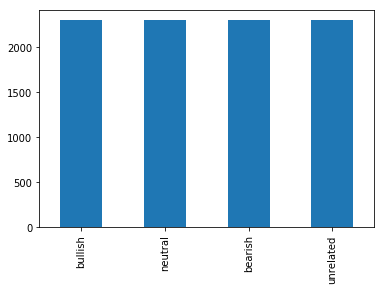

In [0]:
df_train_oversampled['sentiment'].value_counts().plot(kind='bar')

# BERT

In [0]:
import pretrainedmodels

## Tokenizing and setting up databunch

In [0]:
from pytorch_pretrained_bert import BertTokenizer
bert_tok = BertTokenizer.from_pretrained(
    "bert-base-uncased",
)

100%|██████████| 231508/231508 [00:00<00:00, 5777684.14B/s]


In [0]:
class FastAiBertTokenizer(BaseTokenizer):
    """Wrapper around BertTokenizer to be compatible with fast.ai"""
    def __init__(self, tokenizer: BertTokenizer, max_seq_len: int=128, **kwargs):
        self._pretrained_tokenizer = tokenizer
        self.max_seq_len = max_seq_len

    def __call__(self, *args, **kwargs):
        return self

    def tokenizer(self, t:str) -> List[str]:
        """Limits the maximum sequence length"""
        return ["[CLS]"] + self._pretrained_tokenizer.tokenize(t)[:self.max_seq_len - 2] + ["[SEP]"]

In [0]:
fastai_bert_vocab = Vocab(list(bert_tok.vocab.keys()))

In [0]:
fastai_tokenizer = Tokenizer(tok_func=FastAiBertTokenizer(bert_tok, max_seq_len=256), pre_rules=[], post_rules=[])



In [0]:
data_clas = TextDataBunch.from_df(".", df_train, df_val, 
                  tokenizer=fastai_tokenizer,
                  vocab=fastai_bert_vocab,
                  include_bos=False,
                  include_eos=False,
                  text_cols="text",
                  label_cols='sentiment',
                  bs=16,
                  collate_fn=partial(pad_collate, pad_first=False, pad_idx=0))

"""databunch with oversampled df to correct for class imbalance"""
# data_clas = TextDataBunch.from_df(".", df_train_oversampled, df_val, 
#                   tokenizer=fastai_tokenizer,
#                   vocab=fastai_bert_vocab,
#                   include_bos=False,
#                   include_eos=False,
#                   text_cols="text",
#                   label_cols='sentiment',
#                   bs=16,
#                   collate_fn=partial(pad_collate, pad_first=False, pad_idx=0))

data_clas.save('data_clas')

In [0]:
data_clas.show_batch()

text,target
"[CLS] [UNK] - 0 . 95 % [UNK] : [UNK] & amp ; [UNK] # et ##fs # daily # market # change tu ##e , may 28 [UNK] # fear - 0 . 29 % [UNK] $ xl ##k - 0 . 38 % ♣ $ q ##q ##q - 0 . 39 % [UNK] $ g ##ld - 0 . 66 % [UNK] $ xl ##y - 0",neutral
"[CLS] buy / add long - term : $ bt ##c - $ usd $ 7 , 83 ##7 . 86 - 149 . 98 ( - 1 . 88 % ) # bit ##co ##in # usd # crypt ##oc ##ur ##ren ##cy 10 : 00 am 5 / 20 / 19 $ usd ##u $ u ##up $ cy ##b $ yin ##n $ yang $ cn $",unrelated
"[CLS] # bit ##co ##in i ' m long - term in $ bt ##c - $ usd 8 , 125 . 97 + 249 . 43 ( + 3 . 17 % ) as of 4 : 19 ##pm bs ##t . market open . $ usd ##u $ u ##up $ cy ##b $ yin ##n $ yang $ cn $ ch ##n $ fx ##ch $ cn",unrelated
"[CLS] [UNK] - 0 . 67 % [UNK] : [UNK] & amp ; [UNK] # et ##fs # daily # market # change wed , may 29 [UNK] 0 . 03 % [UNK] $ g ##ld 0 . 02 % [UNK] $ xl ##b [UNK] # down - 0 . 19 % [UNK] $ xl ##f - 0 . 45 % [UNK] $ xl ##i - 0 . 59 %",neutral
"[CLS] [UNK] - 0 . 93 % [UNK] : [UNK] & amp ; [UNK] # et ##fs # daily # market # change fr ##i , may 31 [UNK] 1 . 35 % [UNK] $ g ##ld 0 . 83 % [UNK] $ xl ##re 0 . 47 % [UNK] $ xl ##u [UNK] # down - 0 . 72 % [UNK] $ xl ##v - 1 . 12 %",neutral


## Using BERT

In [0]:
from pytorch_pretrained_bert.modeling import BertConfig, BertForSequenceClassification, BertForNextSentencePrediction, BertForMaskedLM
bert_model_class = BertForSequenceClassification.from_pretrained('bert-base-uncased', num_labels=4)



100%|██████████| 407873900/407873900 [00:09<00:00, 44846989.79B/s]


In [0]:
model = bert_model_class

### Classification

Not using mixed precision yet, do that after lr_find()

In [0]:

learn = Learner(data_clas,
               model,
               loss_func = FlattenedLoss(LabelSmoothingCrossEntropy, axis=-1),
               metrics = [accuracy])


# learn = Learner(databunch_1,
#                model,
#                loss_func = nn.BCEWithLogitsLoss(),
#                metrics = [accuracy])
# # learn.to_fp16()

Splitting bert for discriminative learning

In [0]:
def bert_clas_split(self) -> List[nn.Module]:
    
    bert = model.bert
    embedder = bert.embeddings
    pooler = bert.pooler
    encoder = bert.encoder
    classifier = [model.dropout, model.classifier]
    n = len(encoder.layer)//3
    print(n)
    groups = [[embedder], list(encoder.layer[:n]), list(encoder.layer[n+1:2*n]), list(encoder.layer[(2*n)+1:]), [pooler], classifier]
    return groups

x = bert_clas_split(model)

4


In [0]:
learn.split([x[0], x[1], x[2], x[3], x[5]]); # should this be x[4]?

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.
Min numerical gradient: 1.32E-04
Min loss divided by 10: 6.92E-05


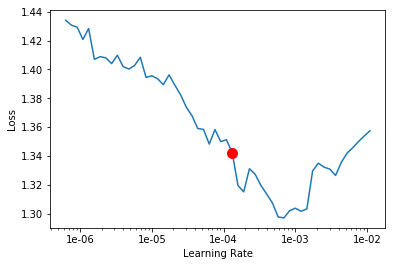

In [0]:
learn.lr_find()
learn.recorder.plot(suggestion = True, skip_end=15)

In [0]:
learn.to_fp16()

lr = 1e-4

"""Training without adjusting the momentum"""
learn.fit_one_cycle(3, 
                    lr, 
                    callbacks=[SaveModelCallback(learn, every='improvement', monitor='accuracy', 
                                                 name='classifier_stage1')])
"""
Clipping momentum
"""


# learn.fit_one_cycle(10, 
#                     lr, 
#                     moms=(0.8,0.7),
#                     callbacks=[SaveModelCallback(learn, every='improvement', monitor='accuracy', 
#                                                  name='classifier_stage1')])

epoch,train_loss,valid_loss,accuracy,time
0,1.044614,0.869819,0.702775,05:32
1,0.828451,0.745140,0.784244,06:04
2,0.676445,0.663156,0.837959,05:54


Better model found at epoch 0 with accuracy value: 0.7027752995491028.
Better model found at epoch 1 with accuracy value: 0.7842435240745544.
Better model found at epoch 2 with accuracy value: 0.837958812713623.


'\nClipping momentum\n'

Additional training by unfreezing the network and applying discriminative learning rates

epoch,train_loss,valid_loss,accuracy,time
0,0.638021,0.649720,0.842435,05:48
1,0.536543,0.619438,0.866607,05:46
2,0.531737,0.609123,0.871083,05:42


Better model found at epoch 0 with accuracy value: 0.8424351215362549.
Better model found at epoch 1 with accuracy value: 0.8666070103645325.
Better model found at epoch 2 with accuracy value: 0.8710832595825195.


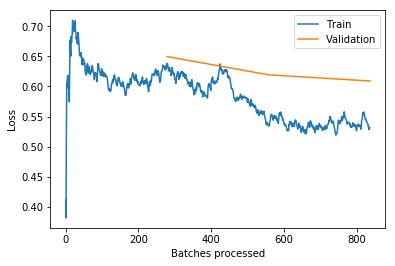

In [0]:
learn.load('classifier_stage1');
learn.unfreeze()


"""Training without adjusting the momentum"""
learn.fit_one_cycle(3, 
                    slice(lr/100, lr), 
                    callbacks=[SaveModelCallback(learn, every='improvement', monitor='accuracy', 
                                                 name='classifier_final')])
"""
Clipping momentum
"""
# learn.fit_one_cycle(10, 
#                    slice(lr/(2.6**4),lr), 
#                    moms=(0.8,0.7),
#                    callbacks=[SaveModelCallback(learn, every='improvement', monitor='accuracy', 
#                                                  name='classifier_stage2')])

learn.recorder.plot_losses()

# Model Inference

In [0]:
learn = Learner(data_clas, 
                model)

# learn = Learner(data_clas,
#                model,
#                loss_func = FlattenedLoss(LabelSmoothingCrossEntropy, axis=-1),
#                metrics = [accuracy])



learn.load('classifier_final', with_opt = False); # makesure learner  is a text_classifier_learner

learn.to_fp32() # bring back to fp32



learn.export(file = 'export_clas.pkl')



In [0]:
phrase = "$GLD will lose value over the next quarter"
learn.predict(phrase)


(Category bearish, tensor(0), tensor([0.6633, 0.1695, 0.1286, 0.0385]))

## Making batch predictions on new dataset

test_df can be loaded in directly from a csv file i.e. 1 days worth of collected tweets

In [0]:
# test_df = pd.read_csv('testset1.csv')

test_df = df_val
learn.data.add_test(test_df['text'])
preds, y, losses = learn.get_preds(ds_type=DatasetType.Test, with_loss = True)
# preds, y, losses = learn.get_preds(ds_type=DatasetType.Test, ordered=True, with_loss = True)


In [0]:

y_pred = torch.argmax(preds, dim= 1).numpy()


print(y_pred, len(y_pred))

pred_labels = []
for pred in y_pred:
    if pred == 0: 
        pred_labels.append('bearish')
    elif pred == 1:
        pred_labels.append('bullish')    
    elif pred == 2:
        pred_labels.append('neutral')
    elif pred == 3:
        pred_labels.append('unrelated')

[2 3 3 3 ... 3 3 2 3] 1117


## Visualizing predictions

visualize the count of predictions

1 = Bearish
2 = Bullish
3 = Neutral
4 = Unrelated

(array([326.,   0.,   0., 544.,   0.,   0.,  61.,   0.,   0., 186.]),
 array([0. , 0.3, 0.6, 0.9, 1.2, 1.5, 1.8, 2.1, 2.4, 2.7, 3. ]),
 <a list of 10 Patch objects>)

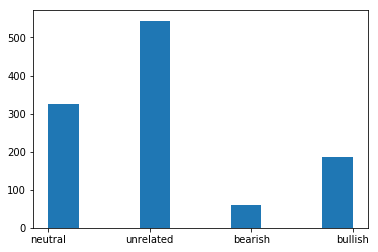

In [0]:
plt.hist(pred_labels)



The distribution of the predictions seems to be inline with the distribution of the val labels

View a confusion matrix of the predictions

y-axis is the true labels

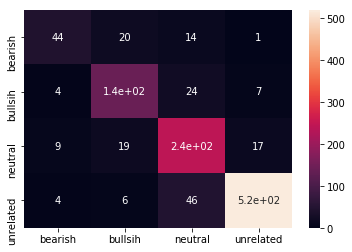

In [0]:
from sklearn.metrics import confusion_matrix
from sklearn.utils.multiclass import unique_labels
import seaborn as sn
cm = confusion_matrix(df_val['sentiment'], pred_labels)

df_cm = pd.DataFrame(cm, index = ['bearish', 'bullsih', 'neutral', 'unrelated'],
                    columns = ['bearish', 'bullsih', 'neutral', 'unrelated'])

sn.heatmap(df_cm, annot=True)

Observations

Performance seems to match what AWD-LSTM is getting, slightly more bullish tweets categorized as bearish, but that could be due to the data split